In [59]:
from math import *
from numpy import sign

import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as integrate
import scipy.optimize as optimize
import matplotlib
import matplotlib.cbook 
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rand

%matplotlib inline  



40


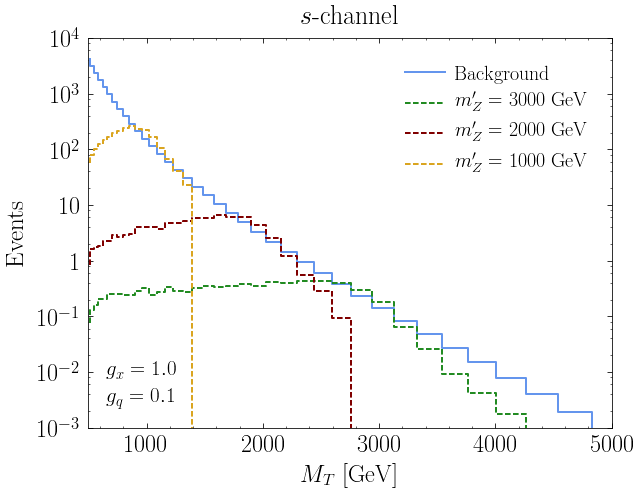

In [213]:
# function to get the background
val=[3.27816*1e-3, 17.1227, -7.85266, 0.00920465, -0.503524]
mylumi=37*1000
# mycut='MEt > 500 & nj>= 2 & pt1 >100 & pt2>100 & MEt> .15*Mt & dphi < 1.0  & 1.1 > eta1-eta2 > -1.1'
mycut='MEt > 100 & nj>= 2 & pt1 >100 & pt2>100 & MEt> .15*Mt & dphi < 1.0  & 1.1 > eta1-eta2 > -1.1'


def binc(b):
    return np.sqrt(b[1:]*b[:-1])

def binw(b):
    return (b[1:]-b[:-1])


def get_bkg(b,nevt=True,lumi=mylumi,param=val):
    bw = np.array(b[1:]-b[:-1])
    bc = np.sqrt(b[1:]*b[:-1])
    x=bc/13000.
    p1=(val[1]+val[2]*np.log(x))
    p2=(val[3]+val[4]*np.log(x))
    if nevt:
        return val[0]*bw*lumi*(1-x)**p1/(x)**p2
    else:
        return val[0]*lumi*(1-x)**p1/(x)**p2
    
Zprime_cxn = pd.read_csv('Zprime_cxn.csv', header=0, delimiter=',', skipinitialspace=True)
logmass = np.log10(Zprime_cxn['mass'])
logcxn = np.log10(Zprime_cxn['cxn'])

from pylab import rcParams
rcParams['figure.figsize'] = 6*.8, 4*.8


def get_sig(mZ, rinv, b, lumi=mylumi, cut=mycut, folder='../gen/ZprimeEventsFixed/'):
    str1='{:d}'.format(mZ)
    if rinv >= .1 and rinv <=.9:
        str2='{:1.1f}'.format(rinv)  
    elif rinv != 1:
        str2='{:1.2f}'.format(rinv)
    else:
        str2='1.0'
    strevt='Zprime_MZ_' + str1 + '_gX_1_gq_0p1_rinv_' + str2 + '.evt'
    strmeta='Zprime_MZ_' + str1 + '_gX_1_gq_0p1_rinv_' + str2 + '.meta'
    data_evt = pd.read_csv(folder+strevt, header=0, delimiter=',', skipinitialspace=True)
    data_meta = pd.read_csv(folder+strmeta, header=0, delimiter=',', skipinitialspace=True)
    data_evt = data_evt.query(cut)
    cxn = 10**np.interp(log10(mZ),logmass,logcxn) * .1**2
    scale=data_meta['cxn']*lumi/data_meta['nevt']
    result, _ =np.histogram(np.asarray(data_evt['Mt']), bins=b,
                            weights=np.repeat(scale,len(data_evt.index)))
#   apply a mask
    mask = (mZ*(0) > b[:-1]) | (b[1:] > mZ*(1+.5))
    return np.where(mask, 0,result)

mybins=10**np.linspace(log10(500),log10(6000),41)
mybins1=10**np.linspace(log10(500),log10(6000),10001)

print(len(binc(mybins)))


sig=get_sig(3000,0.3,mybins)
sig1=get_sig(2000,0.3,mybins)
sig2=get_sig(1000,0.3,mybins)


bkg=get_bkg(mybins)


fig=plt.figure("m", figsize=(9,7))
# plt.subplots_adjust(left=0.3, right=0.90, top=0.9, bottom=0.2)

mybinw=binw(mybins)
#mybinw=mybinw/mybinw
plt.step(binc(mybins),get_bkg(mybins)/mybinw,label=r'$\textrm{Background}$',lw=2)
plt.step(binc(mybins),(10*sig+0*get_bkg(mybins))/mybinw,linestyle='--',lw=2,label=r'$m_Z^\prime=$ 3000 GeV')
plt.step(binc(mybins),(10*sig1+0*get_bkg(mybins))/mybinw,linestyle='--',lw=2,label=r'$m_Z^\prime=$ 2000 GeV')
plt.step(binc(mybins),(10*sig2+0*get_bkg(mybins))/mybinw,linestyle='--',lw=2,label=r'$m_Z^\prime=$ 1000 GeV')


plt.xlim([500,5000])
plt.ylim([1e-3,10000])

plt.yscale('log')

plt.xlabel("$M_T$ [GeV]", fontsize = 24)
plt.ylabel("Events", fontsize = 25)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

plt.tick_params(axis='both', which='major', labelsize=24)

ticklabels = ["whatever","$10^{-3}$","$10^{-2}$","$10^{-1}$","$1$","$10$","$10^2$","$10^3$","$10^4"]
ax.set_yticklabels(ticklabels)

leg = plt.legend(bbox_to_anchor=(0, 0, 0.97, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5,
           borderaxespad=0.)


plt.text(650,8e-3, "$g_x = 1.0$", fontsize = 21)
plt.text(650,2.5e-3, "$g_q = 0.1$", fontsize = 21)
plt.title("$s$-channel", fontsize = 26)
plt.tight_layout()
plt.savefig("MT_Zprime.pdf")

In [98]:
from scipy.optimize import bisect
def limit(sig,bkg):
    
    def func_root(x):
        part1 = bkg > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg[part1]
        qcd_2 = bkg[part2]
        sig_1 = sig[part1]
        sig_2 = sig[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.05**2*sb1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 2
        return my_val
    
    soln = bisect(func_root, -10.,4.)
    return 10**soln

sig=get_sig(2200,0.2,mybins)
bkg=get_bkg(mybins)

rinv=np.array([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1])
masses=np.arange(1000,4100,100)

result=np.zeros([len(rinv),len(masses)])

for ir,r in enumerate(rinv):
    for im,m in enumerate(masses):
        result[ir, im]=limit(get_sig(m,r,mybins),bkg)


In [143]:
excl_small = np.array([ 1231.61804788,  2007.44706086,  2285.1625316 ,  2375.73067325,
        2410.39373596,  2391.62043509,  2296.58654639,  2166.81304371,
        1971.1494719 ,  1684.96264354,  1200.66333998,  1006.00818657,
         812.48116507])

excl_large = np.array([ 451.44072327,   760.95366257,  1135.37463689,  1292.19838542,
        1479.49313551,  1689.5121468 ,  1817.3806336 ,  1964.70332323,
        2098.34008297,  2124.81393547,  1912.28049317,  1909.37075397,
        1835.15793187])

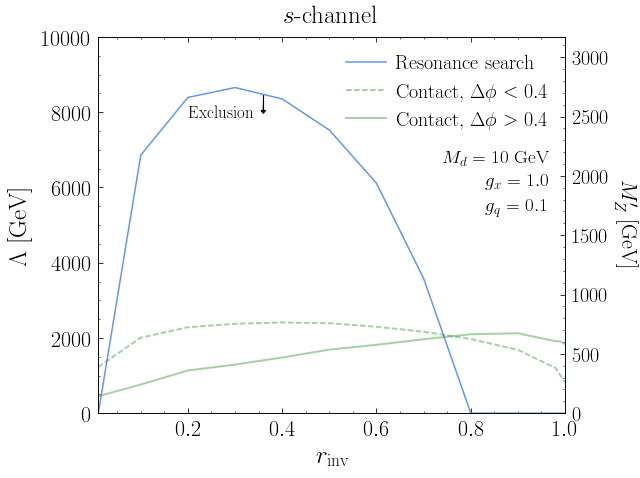

In [261]:
from scipy.optimize import fsolve

from pylab import rcParams
rcParams['figure.figsize'] = 6*1.5, 4.5*1.5

mass_limit=np.zeros(len(rinv))
for i,r in enumerate(rinv):
    mymass = np.insert(masses,0,0)
    masslist = np.insert(result[i],0,0)    
    mass_limit[i] = fsolve(lambda mZ: 1-np.interp(mZ, mymass, masslist), 3000)[0]

final_limit=np.where(mass_limit<1000, 0,mass_limit)

# print(mass_limit)


final_limit[-1]=0
cutoff = final_limit/sqrt(.1)

plt.plot(rinv, cutoff, color='cornflowerblue', label="Resonance search")

cutoff=10000
plt.plot(rinv, excl_small, lw=2, 
                 color='forestgreen', ls='--', label=r'Contact, $\Delta\phi < 0.4$', alpha=0.4)
plt.plot(rinv, excl_large, lw=2, 
                 color='forestgreen', label=r'Contact, $\Delta\phi > 0.4$', alpha=0.4)



plt.xlim(0.01,1)
plt.ylim(0,1e4)
# plt.xscale("log")
plt.ylabel("$\Lambda$ [GeV]", fontsize = 25)
plt.xlabel("$r_\mathrm{inv}$", fontsize = 25)

leg = plt.legend(
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5,
            loc ='upper right')


plt.title("$s$-channel", fontsize = 25)

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.02])

plt.tick_params(axis='both', which='major', labelsize=22)

plt.text(.74,9200-2600, "$M_d = 10$ GeV", fontsize = 19)
plt.text(.83,8570-2600, "$g_x = 1.0$", fontsize = 19)
plt.text(.83,7900-2600, "$g_q = 0.1$", fontsize = 19)

ax = plt.axes()
ax.arrow(.36,8450, 0., -400, head_width=0.01, head_length=80, fc='k', ec='k')
plt.text(.20,7850,"Exclusion",fontsize=17)

ax2 = ax.twinx()

ax2.set_ylabel("$M_Z^\prime$ [GeV]", rotation=270,labelpad=25)

ax2.plot(rinv, final_limit, ls='--',lw=0)
ax2.set_ylim(0,3170)

plt.xlim(0.01,1)

plt.tight_layout()
plt.savefig("mZp_rinv.pdf")

# print(final_limit)

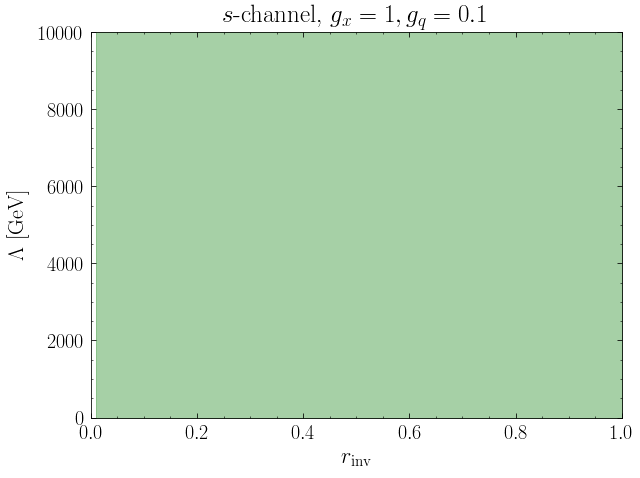

In [260]:
plt.fill_between(rinv,np.zeros_like(cutoff), cutoff, color='forestgreen', alpha=.4)
plt.xlim(0,1)
plt.ylim(0,10000)
# plt.xscale("log")
plt.ylabel("$\Lambda$ [GeV]")
plt.xlabel("$r_\mathrm{inv}$")

plt.legend(loc='upper right')
plt.title("$s$-channel, $g_x = 1, g_q = 0.1$", fontsize = 25)
plt.tight_layout()

### Read input

In [37]:
def readfile(name, folder='../gen/ZprimeEventsFixed/', lumi=1, cxn=None):
    
    data = pd.read_csv(folder+name+'.evt', header=0, delimiter=',', skipinitialspace=True)
    data.meta = pd.read_csv(folder+name+'.meta', header=0, delimiter=',', skipinitialspace=True)
    if 'weight' in data.columns:
        data['weight'] *= (data.meta['cxn']*lumi/data.meta['sum_weight'])[0]
    else:
        data['weight'] = (data.meta['cxn']*lumi / data.meta['nevt'])[0]  
    if cxn is not None:
        data['weight'] = (cxn*lumi / data.meta['nevt'])[0]  
    return data

cut='MEt > 200 & MEt > .15*Mt & dphi < 1.0  & 1.1 > eta1-eta2 > -1.1'
bkg = ['bkg_ttbar_dilep_0',  'bkg_ttbar_semilep_0',  'bkg_Wj_0',  'bkg_Zj_0']
bkg = [ readfile(f, 'BkgNtuplesWithMT//') for f in bkg ]
bkg = [ f.query(cut) for f in bkg ]

b = 10**np.linspace(log10(500),log10(10000),101)

cxn3000= .03951
cxn5000= .0103

def get_str(rinv):
    if rinv >= .1 and rinv <=.9:
        str2='{:1.1f}'.format(rinv)  
    elif rinv != 1:
        str2='{:1.2f}'.format(rinv)
    else:
        str2='1.0'
    return str2

def get_sig(mass):
    str1='{:d}'.format(mass)
#     strevt='Zprime_MZ_' + str1 + '_gX_1_gq_0p1_rinv_' + str2 + '.evt'
#     strmeta='Zprime_MZ_' + str1 + '_gX_1_gq_0p1_rinv_' + str2 + '.meta'

    sig = ['Zprime_MZ_' + str1 + '_gX_1_gq_0p1_rinv_' + get_str(r) for r in  rinv]
    
#     sig = [ 'monojet_mass_rinv0.01',
#             'monojet_mass_rinv0.1',
#             'monojet_mass_rinv0.2',
#             'monojet_mass_rinv0.3',
#             'monojet_mass_rinv0.4',
#             'monojet_mass_rinv0.5',
#             'monojet_mass_rinv0.6',
#             'monojet_mass_rinv0.7',
#             'monojet_mass_rinv0.8',
#             'monojet_mass_rinv0.9',
#             'monojet_mass_rinv0.98',
#             'monojet_mass_rinv0.99',
#             'monojet_mass_rinv1.0' ]
    sig = [ s.replace('mass',str(mass)) for s in sig ]
    if mass == 3000:
        sig = [readfile(f, cxn=cxn3000) for f in sig]
        sig_cxn = [ cxn3000 for f in sig ]
    elif mass == 5000:
        sig = [readfile(f, cxn=cxn5000) for f in sig]
        sig_cxn = [ cxn5000 for f in sig ]
    else:
        sig = [readfile(f) for f in sig]
        sig_cxn = [ f.meta['cxn'] for f in sig ]
        
    sig = [ f.query(cut) for f in sig]
    sig_Mt = [ np.histogram(f['Mt'],bins=b,weights=f['weight'])[0] for f in sig ]
    return sig_Mt

sig3000=get_sig(3000)
sig5000=get_sig(5000)

IOError: File ../gen/ZprimeEventsFixed/Zprime_MZ_5000_gX_1_gq_0p1_rinv_0.01.evt does not exist

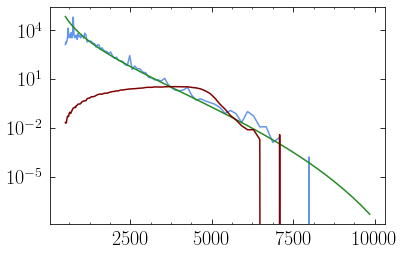

In [20]:
bw = np.array(b[1:]-b[:-1])
bc = np.sqrt(b[1:]*b[:-1])

bkg_errbins = np.asarray([ np.histogram(f['Mt'],bins=b, weights = f['weight']**2)[0] for f in bkg ])
total_bkgerr=np.sqrt(bkg_errbins.sum(axis=0))

bkg_bins = np.asarray([ np.histogram(f['Mt'],bins=b, weights = f['weight'])[0] for f in bkg ])
total_bkg=bkg_bins.sum(axis=0)

val=[3.27816*1e-3, 17.1227, -7.85266, 0.00920465, -0.503524]

def func(b,param=val):
    x=b/13000.
    p1=(val[1]+val[2]*np.log(x))
    p2=(val[3]+val[4]*np.log(x))
    return val[0]*(1-x)**p1/(x)**p2

lumi=37*1000
plt.plot(bc,total_bkg*lumi)
plt.plot(bc,func(bc)*bw*lumi)
plt.plot(bc,sig5000[5]*lumi)
plt.yscale('log')
plt.show()

[  16.65288478    2.24727784    1.50436714    1.37437737    1.51087856
    1.82360243    2.5037579     3.97729772    7.58550299   19.16986201
   80.65051381  115.87687983  171.6086075 ]
[  13.30830491    1.74678879    1.12634779    1.03160959    1.10951256
    1.37180559    1.9500908     3.14228233    6.28311033   19.1438003
  167.72897938  323.52898947  597.95894646]


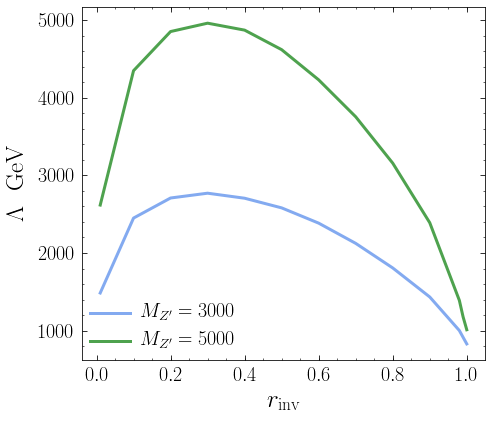

In [21]:
from scipy.optimize import bisect
def limit(sig,lumi_scale=37*1000):
    
    sig_c = sig*lumi_scale
    bkg_c = func(bc)*bw*lumi_scale  
    def func_root(x):
        part1 = bkg_c > 20
        part2 = np.logical_not(part1)
        qcd_1 = bkg_c[part1]
        qcd_2 = bkg_c[part2]
        sig_1 = sig_c[part1]
        sig_2 = sig_c[part2]

        sig_t1 = (10**x)*sig_1
        sig_t2 = (10**x)*sig_2
        
        sb1 = qcd_1 + sig_1
        sb2 = qcd_2 + sig_2
        
        normpart = sig_t1**2/(2*(sb1+0.05**2*sb1**2))
        logpart = np.where(qcd_2 > 1e-3, -qcd_2*np.log(1+sig_t2/qcd_2), 0)
        my_val = np.sum(normpart)+(np.sum(logpart)+np.sum(sig_t2)) - 3.84
        return my_val
    
    soln = bisect(func_root, -10.,4.)
    return soln

rinv=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.98,.99,1]
factor3000=np.asarray([ 10**limit(sig3000[i]/4.0) for i in range(len(rinv))])
factor5000=np.asarray([ 10**limit(sig5000[i]/4.0) for i in range(len(rinv))])


plt.figure()

fig=plt.figure("m", figsize=(8,7))
plt.subplots_adjust(left=0.2, right=0.90, top=0.9, bottom=0.2)

print(factor3000)
print(factor5000)

plt.plot(rinv,3000./factor3000**(1/4.0),label=r'$M_{Z^{\prime}}=3000$',lw=3,alpha=.8)
plt.plot(rinv,5000./factor5000**(1/4.0),label=r'$M_{Z^{\prime}}=5000$',lw=3,alpha=.8)

plt.xlabel(r'$ r_{\rm inv}$', fontsize=25)
plt.ylabel(r'$ \Lambda\,\,{\rm\; GeV}$', fontsize=25)

plt.legend(bbox_to_anchor=(0, 0, .95, 0.95),
           fontsize=20, ncol=1,frameon=False,
           handletextpad=.5, columnspacing=.8,
           borderaxespad=0.)

plt.savefig("cutoff_zprime.png")